In [26]:
%pip install torch torchvision torchaudio torch-geometric
%pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [27]:
import torch
from torch.utils.data import random_split
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt

In [28]:
plt.ion() # Enable interactive plotting
def drawnow():
    """Force draw the current plot."""
    plt.gcf().canvas.draw()
    plt.gcf().canvas.flush_events()

In [29]:
device = 'cpu'

In [30]:
# Load data
dataset = TUDataset(root='./data/', name='MUTAG').to(device)
node_feature_dim = 7

# Split into training and validation
rng = torch.Generator().manual_seed(0)
train_dataset, validation_dataset, test_dataset = random_split(dataset, (100, 44, 44), generator=rng)

# Create dataloader for training and validation
train_loader = DataLoader(train_dataset, batch_size=100)
validation_loader = DataLoader(validation_dataset, batch_size=44)
test_loader = DataLoader(test_dataset, batch_size=44)

In [31]:
train_dataset, validation_dataset, test_dataset

print(train_dataset.dataset[0])

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


In [32]:
data_batch = next(iter(train_loader))
print(data_batch)

print(f'x (node features): {data_batch.x.shape}')
print(f'edge_index (edges): {data_batch.edge_index.shape}')
print(f'edge_attr (edge features): {data_batch.edge_attr.shape}')
print(f'batch (Index of which graph in the batch each node belongs to): {data_batch.batch.shape}')

DataBatch(edge_index=[2, 3936], x=[1784, 7], edge_attr=[3936, 4], y=[100], batch=[1784], ptr=[101])
x (node features): torch.Size([1784, 7])
edge_index (edges): torch.Size([2, 3936])
edge_attr (edge features): torch.Size([3936, 4])
batch (Index of which graph in the batch each node belongs to): torch.Size([1784])


In [33]:
class SimpleGNN(torch.nn.Module):
    """Simple graph neural network for graph classification

    Keyword Arguments
    -----------------
        node_feature_dim : Dimension of the node features
        state_dim : Dimension of the node states
        num_message_passing_rounds : Number of message passing rounds
    """

    def __init__(self, node_feature_dim, state_dim, num_message_passing_rounds):
        super().__init__()

        # Define dimensions and other hyperparameters
        self.node_feature_dim = node_feature_dim # embedding dimension
        self.state_dim = state_dim # hidden state dimension
        self.num_message_passing_rounds = num_message_passing_rounds

        # Input network
        self.input_net = torch.nn.Sequential(
            torch.nn.Linear(self.node_feature_dim, self.state_dim),
            torch.nn.ReLU()
            )

        # Message networks
        self.message_net = torch.nn.ModuleList([
            torch.nn.Sequential(
                torch.nn.Linear(self.state_dim, self.state_dim),
                torch.nn.ReLU()
            ) for _ in range(num_message_passing_rounds)])

        # Update network
        self.update_net = torch.nn.ModuleList([
            torch.nn.Sequential(
                torch.nn.Linear(self.state_dim, self.state_dim),
                torch.nn.ReLU()
            ) for _ in range(num_message_passing_rounds)])

        # State output network
        self.output_net = torch.nn.Linear(self.state_dim, 1)

    def forward(self, x, edge_index, batch):
        """Evaluate neural network on a batch of graphs.

        Parameters
        ----------
        x : torch.tensor (num_nodes x num_features)
            Node features.
        edge_index : torch.tensor (2 x num_edges)
            Edges (to-node, from-node) in all graphs.
        batch : torch.tensor (num_nodes)
            Index of which graph each node belongs to.

        Returns
        -------
        out : torch tensor (num_graphs)
            Neural network output for each graph.

        """
        # Extract number of nodes and graphs
        num_graphs = batch.max()+1
        num_nodes = batch.shape[0]

        # Initialize node state from node features
        state = self.input_net(x)
        # state = x.new_zeros([num_nodes, self.state_dim]) # Uncomment to disable the use of node features

        # Loop over message passing rounds
        for r in range(self.num_message_passing_rounds):
            # Compute outgoing messages
            message = self.message_net[r](state)

            # Aggregate: Sum messages
            aggregated = x.new_zeros((num_nodes, self.state_dim))
            aggregated = aggregated.index_add(0, edge_index[1], message[edge_index[0]])

            # Update states
            state = state + self.update_net[r](aggregated)

        # Aggretate: Sum node features
        graph_state = x.new_zeros((num_graphs, self.state_dim))
        graph_state = torch.index_add(graph_state, 0, batch, state)

        # Output
        out = self.output_net(graph_state).flatten()
        return out

In [ ]:
# Instantiate the model
state_dim = 16
num_message_passing_rounds = 4
model = SimpleGNN(node_feature_dim, state_dim, num_message_passing_rounds).to(device)

# Loss function
cross_entropy = torch.nn.BCEWithLogitsLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)


In [35]:
train_accuracies = []
train_losses = []
validation_accuracies = []
validation_losses = []

Epoch 10
- Learning rate   = 9.5e-03
- Train. accuracy = 0.670
         loss     = 0.598
- Valid. accuracy = 0.659
         loss     = 0.591
Epoch 20
- Learning rate   = 9.0e-03
- Train. accuracy = 0.670
         loss     = 0.587
- Valid. accuracy = 0.659
         loss     = 0.627
Epoch 30
- Learning rate   = 8.6e-03
- Train. accuracy = 0.680
         loss     = 0.537
- Valid. accuracy = 0.659
         loss     = 0.560
Epoch 40
- Learning rate   = 8.2e-03
- Train. accuracy = 0.670
         loss     = 0.513
- Valid. accuracy = 0.659
         loss     = 0.550
Epoch 50
- Learning rate   = 7.8e-03
- Train. accuracy = 0.680
         loss     = 0.500
- Valid. accuracy = 0.659
         loss     = 0.543
Epoch 60
- Learning rate   = 7.4e-03
- Train. accuracy = 0.720
         loss     = 0.489
- Valid. accuracy = 0.659
         loss     = 0.531
Epoch 70
- Learning rate   = 7.0e-03
- Train. accuracy = 0.730
         loss     = 0.477
- Valid. accuracy = 0.659
         loss     = 0.524
Epoch 80
- Le

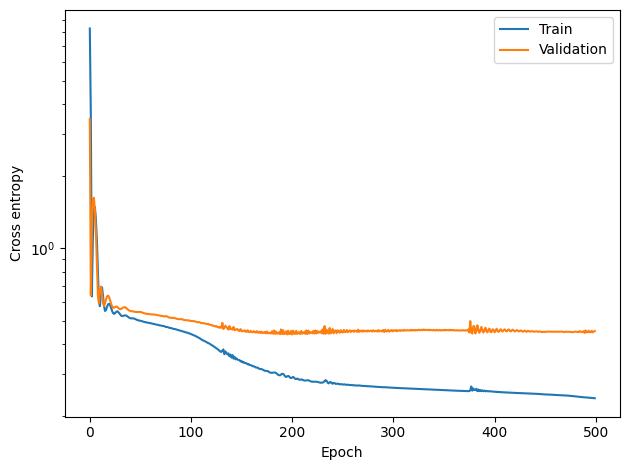

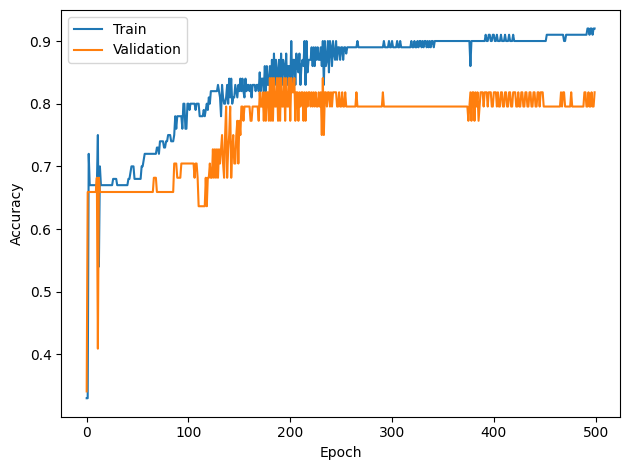

In [36]:
# Number of epochs
epochs = 500

for epoch in range(epochs):
    # Loop over training batches
    model.train()
    train_accuracy = 0.
    train_loss = 0.
    for data in train_loader:
        out = model(data.x, data.edge_index, batch=data.batch)
        loss = cross_entropy(out, data.y.float())

        # Gradient step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute training loss and accuracy
        train_accuracy += sum((out>0) == data.y).detach().cpu() / len(train_loader.dataset)
        train_loss += loss.detach().cpu().item() * data.batch_size / len(train_loader.dataset)
    
    # Learning rate scheduler step
    scheduler.step()

    # Validation, print and plots
    with torch.no_grad():    
        model.eval()
        # Compute validation loss and accuracy
        validation_loss = 0.
        validation_accuracy = 0.
        for data in validation_loader:
            out = model(data.x, data.edge_index, data.batch)
            validation_accuracy += sum((out>0) == data.y).cpu() / len(validation_loader.dataset)
            validation_loss += cross_entropy(out, data.y.float()).cpu().item() * data.batch_size / len(validation_loader.dataset)

        # Store the training and validation accuracy and loss for plotting
        train_accuracies.append(train_accuracy)
        train_losses.append(train_loss)
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)

        # Print stats and update plots
        if (epoch+1)%10 == 0:
            print(f'Epoch {epoch+1}')
            print(f'- Learning rate   = {scheduler.get_last_lr()[0]:.1e}')
            print(f'- Train. accuracy = {train_accuracy:.3f}')
            print(f'         loss     = {train_loss:.3f}')
            print(f'- Valid. accuracy = {validation_accuracy:.3f}')
            print(f'         loss     = {validation_loss:.3f}')

            plt.figure('Loss').clf()
            plt.plot(train_losses, label='Train')
            plt.plot(validation_losses, label='Validation')
            plt.legend()
            plt.xlabel('Epoch')
            plt.ylabel('Cross entropy')
            plt.yscale('log')
            plt.tight_layout()
            drawnow()

            plt.figure('Accuracy').clf()
            plt.plot(train_accuracies, label='Train')
            plt.plot(validation_accuracies, label='Validation')
            plt.legend()
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.tight_layout()
            drawnow()

In [37]:
with torch.no_grad():
    data = next(iter(test_loader))
    out = model(data.x, data.edge_index, data.batch).cpu()
    torch.save(out, 'test_predictions.pt')